In [1]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 1

## 1.1 
Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.

In [2]:
SST = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")#load data

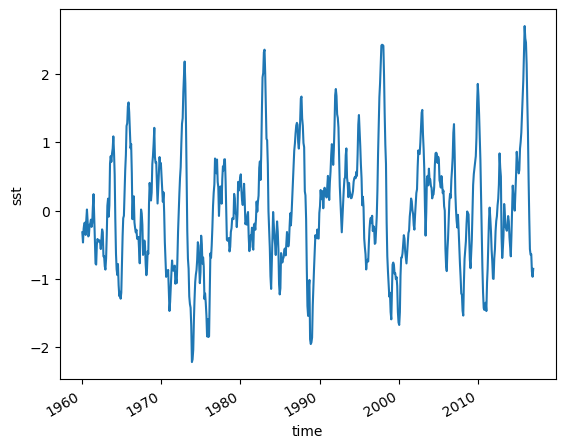

In [3]:
group_data=SST.sel(lon=slice(190,240),lat=slice(-5,5)).mean(dim=['lat','lon']).groupby('time.month')
SST_anom=group_data-group_data.mean()#obtain anomalies
SST_anom.sst.plot()#plot anomalies

## 1.2
Visualize the computed Niño 3.4.

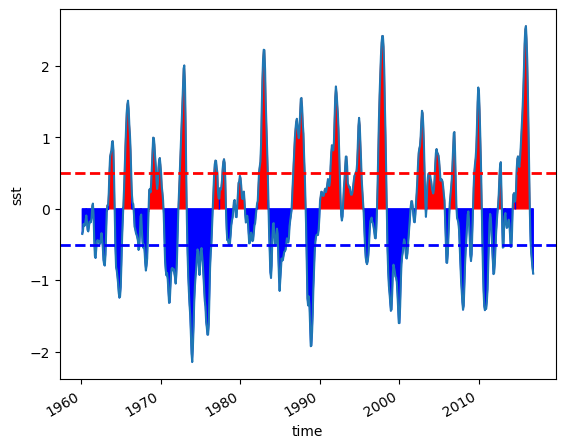

In [4]:
SST_anom_rolling = SST_anom.rolling(time=3, center=True).mean()#calculate Niño 3.4 index typically uses a 3-month running mean
SST_anom_rolling.sst.plot()#plot index
plt.fill_between(SST_anom_rolling.time, 0, SST_anom_rolling.sst, where=(SST_anom.sst > 0), color='red', interpolate=True)
plt.fill_between(SST_anom_rolling.time, 0, SST_anom_rolling.sst, where=(SST_anom.sst < 0), color='blue', interpolate=True)
plt.axhline(0.5, color='red', linestyle='--', linewidth=2)
plt.axhline(-0.5, color='blue', linestyle='--', linewidth=2)

# 2

## 2.1
Make a 2D plot of the time-mean TOA longwave, shortwave, and solar radiation for all-sky conditions. Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux.

In [5]:
ds = xr.open_dataset("CERES_EBAF-TOA_200003-201701.nc", engine="netcdf4")#load data

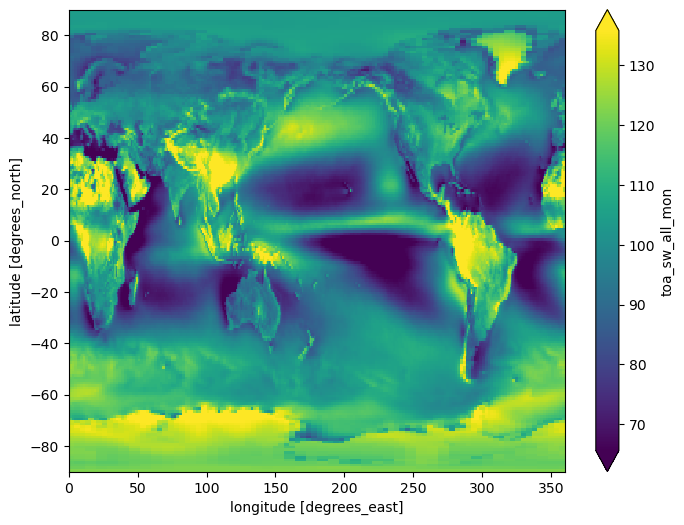

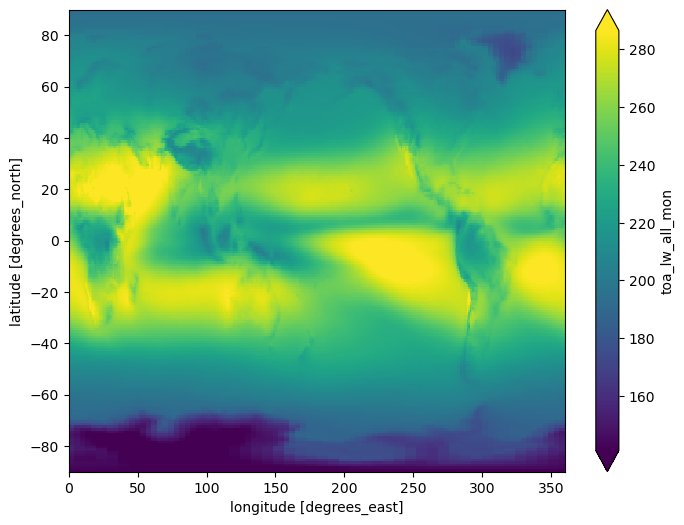

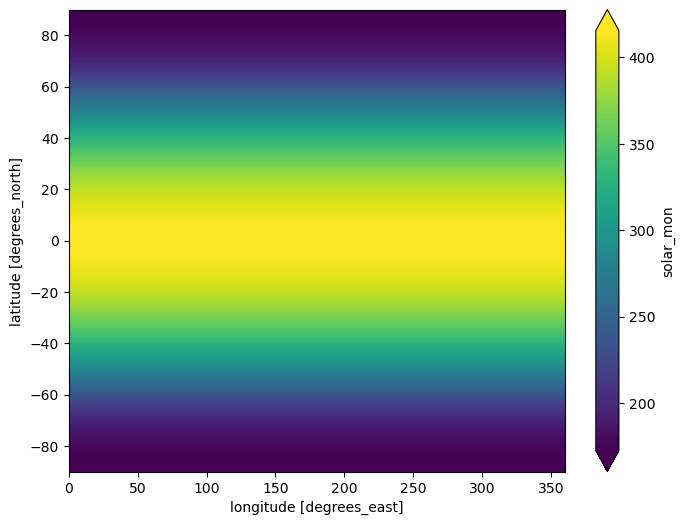

In [6]:
ds.toa_sw_all_mon.mean(dim='time').plot(size=6, robust=True)#calculate time-mean TOA shortwave for all-sky conditions and plot
ds.toa_lw_all_mon.mean(dim='time').plot(size=6, robust=True)#calculate time-mean TOA longtwave for all-sky conditions and plot
ds.solar_mon.mean(dim='time').plot(size=6, robust=True)#calculate time-mean solar radiation and plot

Text(0.5, 1.0, 'TOA net flux')

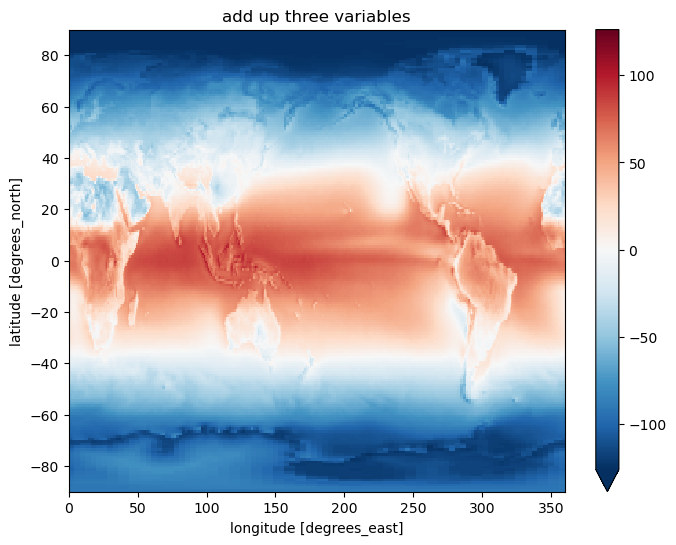

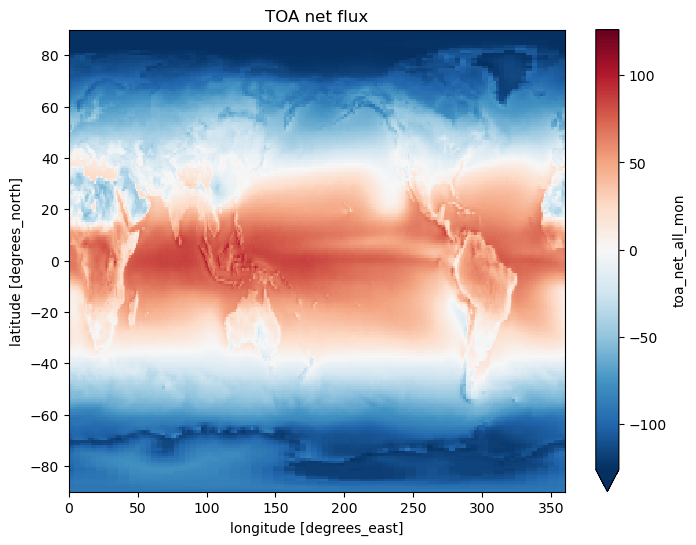

In [7]:
sum_lss=ds.solar_mon.mean(dim='time')-ds.toa_sw_all_mon.mean(dim='time')-ds.toa_lw_all_mon.mean(dim='time')#add up three variables
sum_lss.plot(size=6, robust=True)#plot
plt.title('add up three variables')
ds.toa_net_all_mon.mean(dim='time').plot(size=6, robust=True)#calculte and plot time-mean TOA net flux for all-sky conditions
plt.title('TOA net flux')

The results of adding three variables are equivalent to TOA net flux

## 2.2
Calculate and verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with the cartoon above.

In [8]:
weights = np.cos(np.deg2rad(ds.lat))# calculate area weights for different latitude
ds.toa_lw_all_mon.weighted(weights).mean()#calculte TOA longwave using area weights

<xarray.DataArray 'toa_lw_all_mon' ()>
array(240.26692, dtype=float32)

The result is closer to total outgoing infrared radiation(239.9)

In [9]:
ds.toa_sw_all_mon.weighted(weights).mean()#calculte TOA shortwave using area weights

<xarray.DataArray 'toa_sw_all_mon' ()>
array(99.13806, dtype=float32)

The result is closer to total reflected solar radiation(99.9)

In [10]:
ds.solar_mon.weighted(weights).mean()#calculte solar radiation using area weights

<xarray.DataArray 'solar_mon' ()>
array(340.28326, dtype=float32)

The result is closer to incoming solar radiation(340.4)

## 2.3
Calculate and plot the total amount of net radiation in each 1-degree latitude band. Label with correct units.

Text(0.5, 0, 'time')

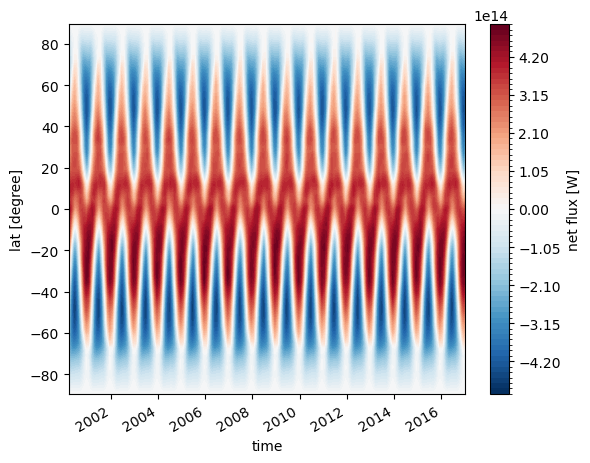

In [11]:
#calculate the total amout of net radiation in each 1-degree latitude using 1-degree in equator is equal to 111km and using area weights
net_lon_sum=ds.toa_net_all_mon.weighted(weights).sum(dim=['lon'])*111000**2
net_lon_sum.plot.contourf(x='time', levels=100).colorbar.set_label('net flux [W]')#plot
plt.ylabel('lat [degree]')
plt.xlabel('time')

Text(0.5, 0, 'lat [degree]')

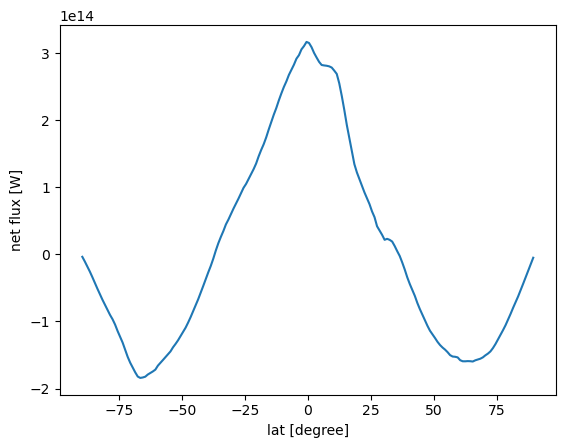

In [12]:
net_lon_sum=ds.toa_net_all_mon.mean(dim='time').weighted(weights).sum(dim=['lon'])*111000**2#calculate time-mean
net_lon_sum.plot()#plot
plt.ylabel('net flux [W]')
plt.xlabel('lat [degree]')

## 2.4
Calculate and plot composites of time-mean outgoing shortwave and longwave radiation for low and high cloud area regions. Here we define low cloud area as ≤25% and high cloud area as ≥75%. Your results should be 2D maps.

Text(0.5, 1.0, 'time-mean shortwave in high cloud area regions')

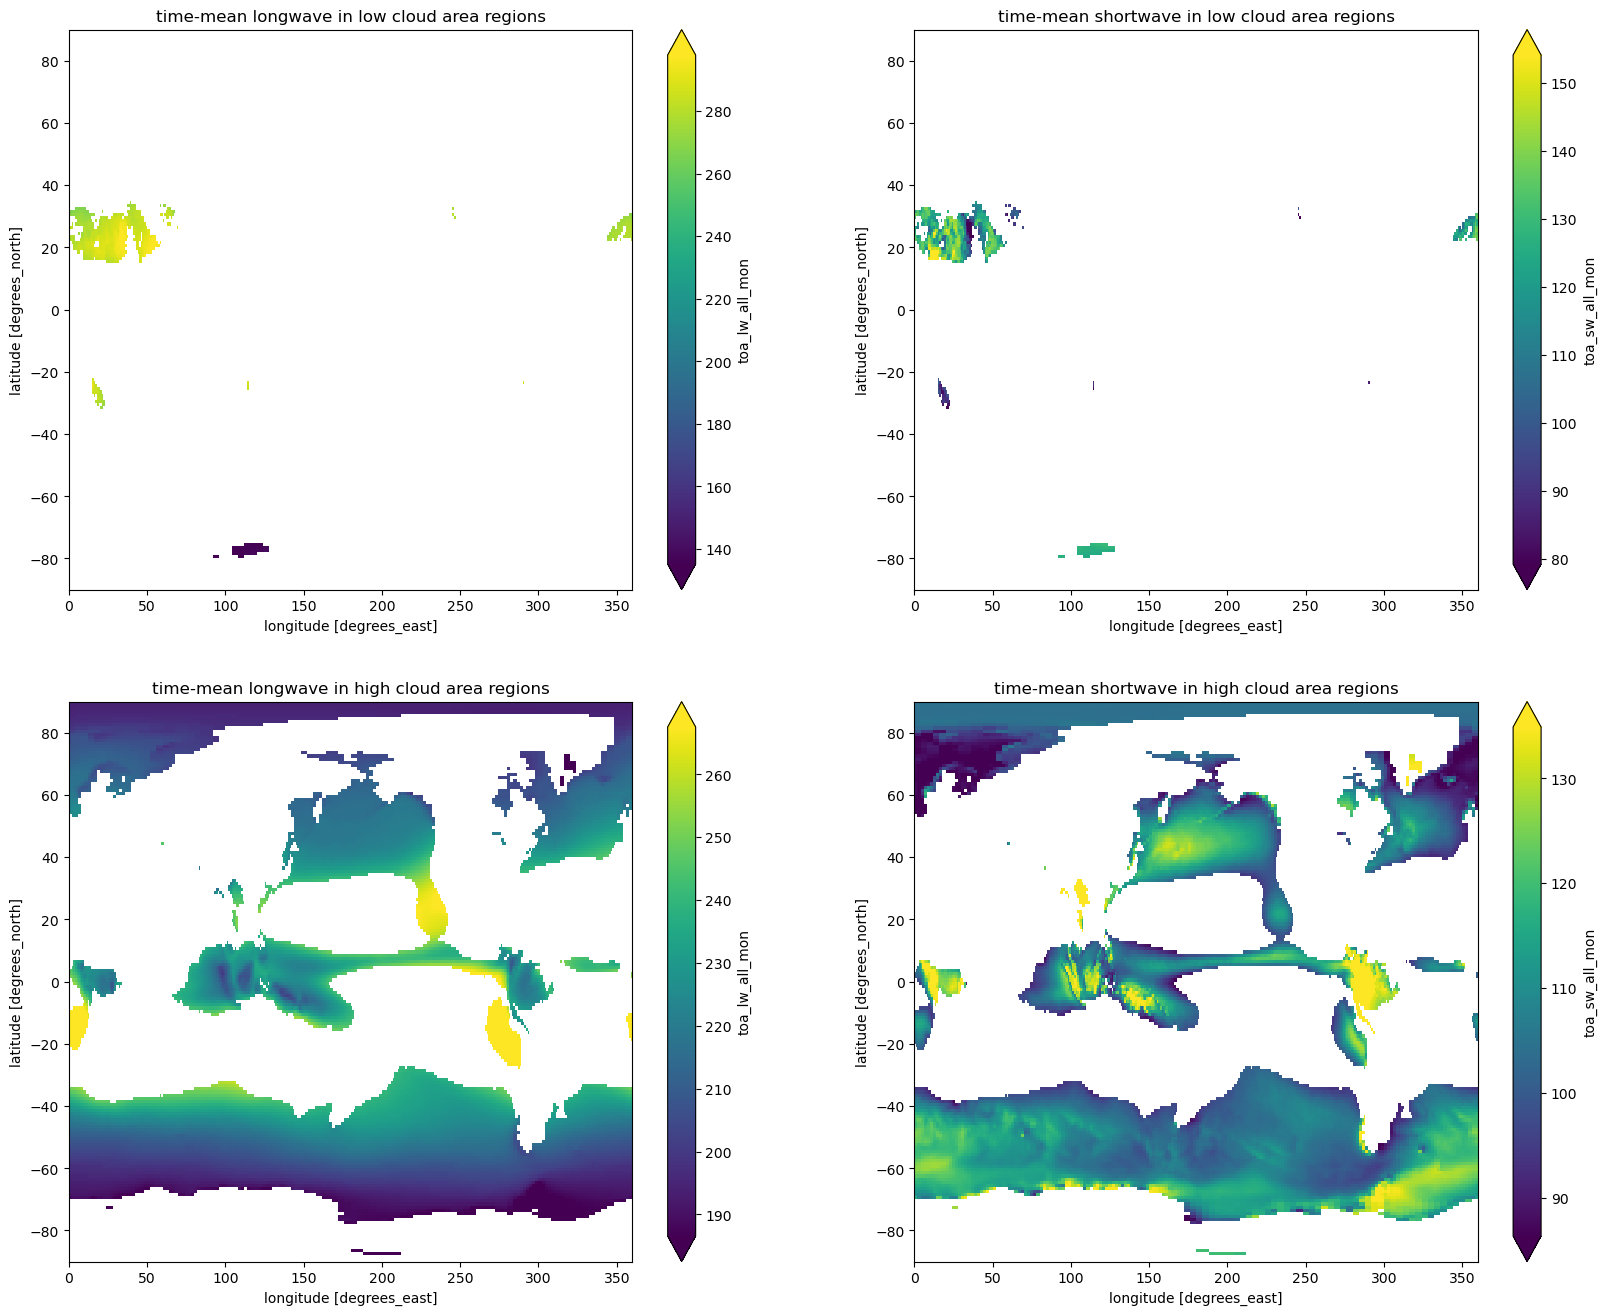

In [13]:
cld_mean=ds.cldarea_total_daynight_mon.mean(dim='time')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20, 16))
#calculate and plot time-mean longwave in low cloud area regions
ds.toa_lw_all_mon.mean(dim='time').where((cld_mean<25)).plot(ax= axes[0,0], robust=True)
axes[0,0].set_title('time-mean longwave in low cloud area regions')
#calculate and plot time-mean shortwave in low cloud area regions
ds.toa_sw_all_mon.mean(dim='time').where((cld_mean<25)).plot(ax= axes[0,1], robust=True)
axes[0,1].set_title('time-mean shortwave in low cloud area regions')
#calculate and plot time-mean longwave in high cloud area regions
ds.toa_lw_all_mon.mean(dim='time').where((cld_mean>75)).plot(ax= axes[1,0], robust=True)
axes[1,0].set_title('time-mean longwave in high cloud area regions')
#calculate and plot time-mean shortwave in high cloud area regions
ds.toa_sw_all_mon.mean(dim='time').where((cld_mean>75)).plot(ax= axes[1,1], robust=True)
axes[1,1].set_title('time-mean shortwave in high cloud area regions')

## 2.5
Calculate the global mean values of shortwave and longwave radiation, composited in high and low cloud regions. What is the overall effect of clouds on shortwave and longwave radiation?

In [14]:
#calulte mean longtwave in low cloud area regions using area weights
lw_low_mean=ds.toa_lw_all_mon.where((cld_mean<25)).weighted(weights).mean()
#calulte mean shorttwave in low cloud area regions using area weights
sw_low_mean=ds.toa_sw_all_mon.where((cld_mean<25)).weighted(weights).mean()
#calulte mean longtwave in high cloud area regions using area weights
lw_high_mean=ds.toa_lw_all_mon.where((cld_mean>75)).weighted(weights).mean()
#calulte mean shortwave in high cloud area regions using area weights
sw_high_mean=ds.toa_sw_all_mon.where((cld_mean>75)).weighted(weights).mean()
print(lw_low_mean,sw_low_mean,lw_high_mean,sw_high_mean)

<xarray.DataArray 'toa_lw_all_mon' ()>
array(280.66214, dtype=float32) <xarray.DataArray 'toa_sw_all_mon' ()>
array(122.5519, dtype=float32) <xarray.DataArray 'toa_lw_all_mon' ()>
array(223.7661, dtype=float32) <xarray.DataArray 'toa_sw_all_mon' ()>
array(109.20605, dtype=float32)


In high cloud regions, both of mean outgoing shortwave and longwave radiation are less than which in low cloud reagions. This means that cloud will reduce outgoing radiation, and the impacts for shortwave radiation may less than longwave radiation.

# 3

## 3.1
Plot a time series of a certain variable with monthly seasonal cycle removed.

In [ ]:
#This dataset is from CMIP6, about future globle precipitation using CMCC-ESM2 model in ssp126 situation
pr=xr.open_dataset('pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_20400101-20641231.nc',engine = 'netcdf4')#load data
pr=pr.pr*24*3600#change the unit from kg m-2 s-1 to mm which is more commonly used

In [ ]:
pr_group=pr.resample(time='M').sum(dim='time').groupby('time.month')# resample the data from daily pr to monthly pr and group by month
pr_anom=pr_group-pr_group.mean()#calculate monthly seasonal cycle removed.
pr_anom.mean(dim=['lat','lon']).plot()#plot

## 3.2
Make at least 5 different plots using the dataset.

In [ ]:
pr.resample(time='M').sum(dim='time').mean(dim='time').plot()#calculate mean-monthly precipitation and plot

In [ ]:
pr.resample(time='Y').sum(dim='time').mean(dim='time').plot()#calculate mean-yearly precipitation and plot

In [ ]:
pr.mean(dim='time').plot()#calculate mean-daily precipitation and plot

In [ ]:
#calculate yearly precipitation in different year and plot
pr.resample(time='Y').sum(dim='time').plot(col="time", col_wrap=6, robust=True)

In [ ]:
#calculate mean-monthly precipitation for 1-12 month and plot
pr_mon=pr.resample(time='M').sum(dim='time').groupby('time.month').mean(dim='time')
pr_mon.plot(col="month", col_wrap=6, robust=True)